# Model Metrics workflow notebook

In [1]:
"""
    Input: config defining model type, device, weights, tilesizes, classes, channels
    Input: Torch dataloader
    
    Output: Json of average/total metrics for model and loader
    Output: list of jsons of metrics for each item in loader
    Output: Same as above with permanent water adjustment
"""

'\n    Input: config defining model type, device, weights, tilesizes, classes, channels\n    Input: Torch dataloader\n    \n    Output: Json of average/total metrics for model and loader\n    Output: list of jsons of metrics for each item in loader\n    Output: Same as above with permanent water adjustment\n'

In [15]:
import torch
import numpy as np
import json

import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

%load_ext autoreload
%autoreload 2

from src.models.utils import model_setup, metrics
from src.models.utils.configuration import AttrDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define a configuration for this experiment

In [3]:
# Define some options
model_name = 'linear' # options: 'unet', 'linear', 'simplecnn'
channel_configuration_name = 'all'

opt = {
    'model': model_name,
    'device': 'cpu',
    'model_folder': f'../../src/models/checkpoints/{model_name}/', # TODO different channel configuration means different model
    'max_tile_size': 128,
    'num_class': 3,
    'channel_configuration' : channel_configuration_name,
    'num_channels': len(model_setup.CHANNELS_CONFIGURATIONS[channel_configuration_name]),
}
opt = AttrDict.from_nested_dicts(opt)

## Load inference function using opt

In [4]:
inference_func = model_setup.model_inference_fun(opt)

Model  : linear
Using latest model: ../../src/models/checkpoints/linear/linear_final_weights.pt


## Load Dataset and create dataloader

In [5]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

In [6]:
from typing import Optional, Tuple, Union


@torch.no_grad()
def read_inference_pair(layer_name:str, window:Optional[Union[rasterio.windows.Window, Tuple[slice,slice]]], 
                        return_ground_truth: bool=False, channels:bool=None, 
                        return_permanent_water=True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, rasterio.Affine]:
    """
    Read a pair of layers from the worldfloods bucket and return them as Tensors to pass to a model, return the transform for plotting with lat/long
    
    Args:
        layer_name: filename for layer in worldfloods bucket
        window: window of layer to use
        return_ground_truth: flag to indicate if paired gt layer should be returned
        channels: list of channels to read from the image
        return_permanent_water: Read permanent water layer raster
    
    Returns:
        (torch_inputs, torch_targets, transform): inputs Tensor, gt Tensor, transform for plotting with lat/long
    """
    tiff_inputs = f"gs://ml4floods/worldfloods/tiffimages/S2/{layer_name}.tif"
    tiff_targets = f"gs://ml4floods/worldfloods/tiffimages/gt/{layer_name}.tif"

    with rasterio.open(tiff_inputs, "r") as rst:
        inputs = rst.read((np.array(channels) + 1).tolist(), window=window)
        # Shifted transform based on the given window (used for plotting)
        transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
        torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
    
    if return_permanent_water:
        tiff_permanent_water = f"gs://ml4floods/worldfloods/tiffimages/PERMANENTWATERJRC/{layer_name}.tif"
        with rasterio.open(tiff_permanent_water, "r") as rst:
            permanent_water = rst.read(1, window=window)  
            torch_permanent_water = torch.tensor(permanent_water)
    else:
        torch_permanent_water = torch.zeros_like(torch_inputs)
        
    if return_ground_truth:
        with rasterio.open(tiff_targets, "r") as rst:
            targets = rst.read(1, window=window)
        
        torch_targets = torch.tensor(targets).unsqueeze(0)
    else:
        torch_targets = torch.zeros_like(torch_inputs)
    
    return torch_inputs, torch_targets, torch_permanent_water, transform

COLORS_WORLDFLOODS = np.array([[0, 0, 0], # invalid
                               [139, 64, 0], # land
                               [0, 0, 139], # water
                               [220, 220, 220]], # cloud
                              dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]

COLORS_WORLDFLOODS_PERMANENT = np.array([[0, 0, 0], # 0: invalid
                                         [139, 64, 0], # 1: land
                                         [237, 0, 0], # 2: flood_water
                                         [220, 220, 220], # 3: cloud
                                         [0, 0, 139], # 4: permanent_water
                                         [60, 85, 92]], # 5: seasonal_water
                                        dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS_PERMANENT = ["invalid", "land", "flood water", "cloud", "permanent water", "seasonal water"]

def gt_with_permanent_water(gt: np.ndarray, permanent_water: np.ndarray)->np.ndarray:
    """ Permanent water taken from: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_YearlyHistory"""
    gt[(gt == 2) & (permanent_water == 3)] = 4 # set as permanent_water
    gt[(gt == 2) & (permanent_water == 2)] = 5 # set as seasonal water
        
    return gt

In [7]:
class DummyWorldFloodsDataset(torch.utils.data.Dataset):
    def __init__(self, layer_names, windows, channels):
        self.inputs = []
        self.targets = []
        self.permanent_water = []
        self.plot_transforms = []
        
        for i in range(len(layer_names)):
            torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(layer_names[i], windows[i], return_ground_truth=True, channels=channels[i])
            
            self.inputs.append(torch_inputs)
            self.targets.append(torch_targets)
            self.permanent_water.append(torch_permanent_water)
            self.plot_transforms.append(transform)
        
        print(len(self.inputs))
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        this_dict = {
            'input': self.inputs[idx],
            'target': self.targets[idx],
            'permanent_water': self.permanent_water[idx],
            'plot_transforms': self.plot_transforms[idx]
        }
        return self.inputs[idx].squeeze(), self.targets[idx].squeeze()

In [8]:
layer_names = ["EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a", "EMSR347_07ZOMBA_DEL_v2_observed_event_a"]
windows = [(slice(254,None),slice(0,256)), (slice(254,None),slice(0,256))]
channels = [model_setup.CHANNELS_CONFIGURATIONS[opt.channel_configuration], model_setup.CHANNELS_CONFIGURATIONS[opt.channel_configuration]]

ds = DummyWorldFloodsDataset(layer_names, windows, channels)

dl = torch.utils.data.DataLoader(ds, batch_size=1)

2


0it [00:00, ?it/s]

[0 1 2]


2it [00:00,  2.96it/s]

[0 1]


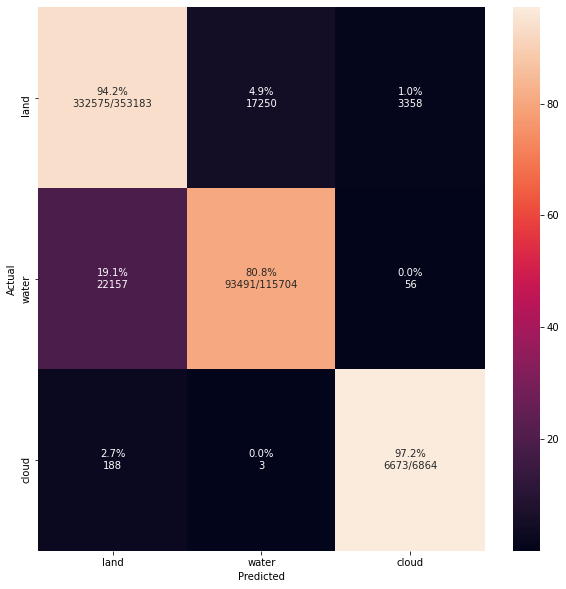

../../src/models/utils/metrics.py:148: RuntimeWarning: invalid value encountered in long_scalars
  fp_rate = fp / (fp+tn)


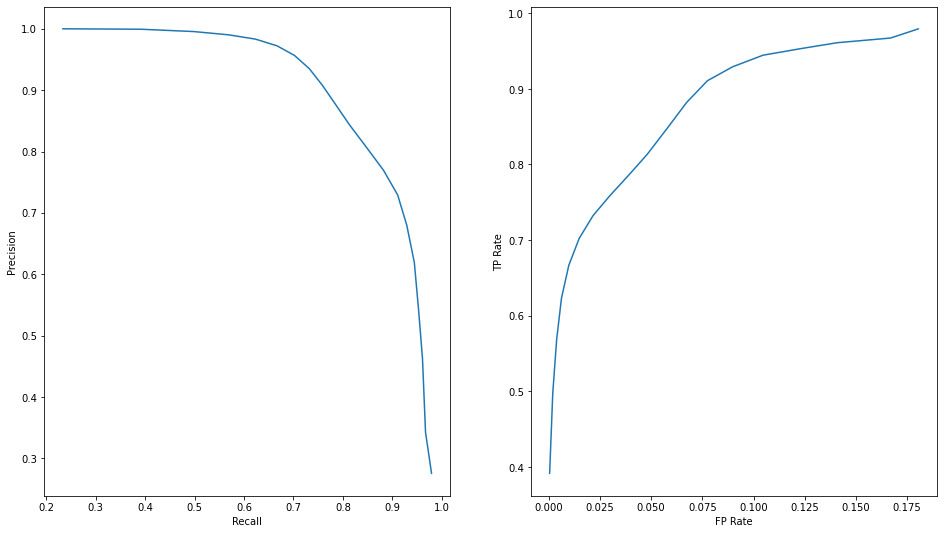

Per Class IOU {
    "cloud": 0.6492508270091457,
    "land": 0.8856197141092009,
    "water": 0.7031671893920591
}


In [18]:
import torch
import numpy as np
import pandas as pd

label_names = ["land","water","cloud"]
mets = metrics.compute_metrics(
    dl,
    inference_func, 
    opt.num_class, 
    label_names=label_names, 
    thresholds_water=np.arange(0, 1, .05), 
    plot=False)
metrics.plot_metrics(mets, label_names)

In [19]:
# Define some options
model_name = 'unet' # options: 'unet', 'linear', 'simplecnn'
channel_configuration_name = 'all'

opt2 = {
    'model': model_name,
    'device': 'cpu',
    'model_folder': f'../../src/models/checkpoints/{model_name}/', # TODO different channel configuration means different model
    'max_tile_size': 128,
    'num_class': 3,
    'channel_configuration' : channel_configuration_name,
    'num_channels': len(model_setup.CHANNELS_CONFIGURATIONS[channel_configuration_name]),
}
opt2 = AttrDict.from_nested_dicts(opt2)

In [20]:
inference_func2 = model_setup.model_inference_fun(opt2)

Model  : unet
Using latest model: ../../src/models/checkpoints/unet/unet_final_weights.pt


0it [00:00, ?it/s]

[0 1 2]


2it [00:49, 24.51s/it]

[0 1]


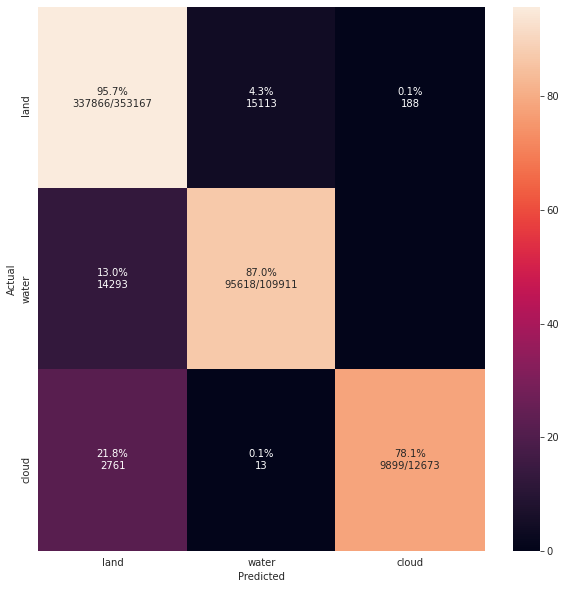

../../src/models/utils/metrics.py:148: RuntimeWarning: invalid value encountered in long_scalars
  fp_rate = fp / (fp+tn)


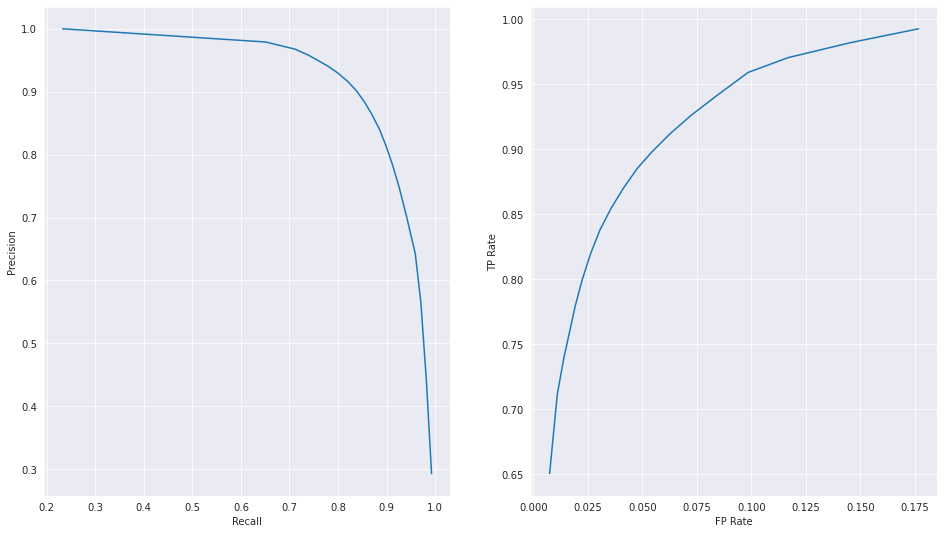

Per Class IOU {
    "cloud": 0.7696913148277739,
    "land": 0.9126062541022795,
    "water": 0.764717643577501
}


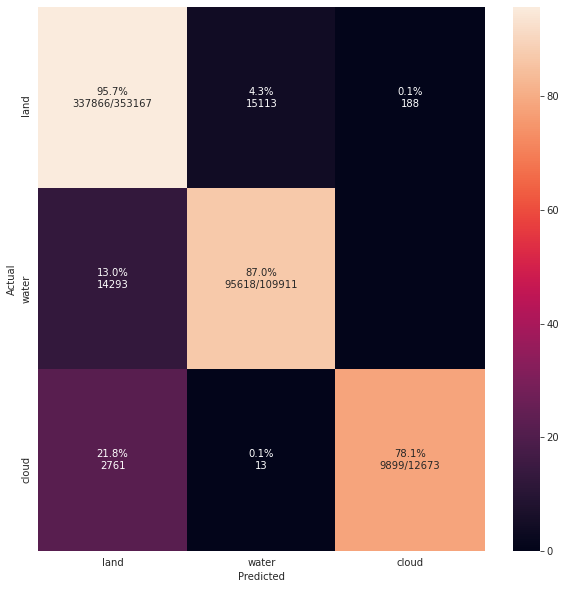

../../src/models/utils/metrics.py:148: RuntimeWarning: invalid value encountered in long_scalars
  fp_rate = fp / (fp+tn)


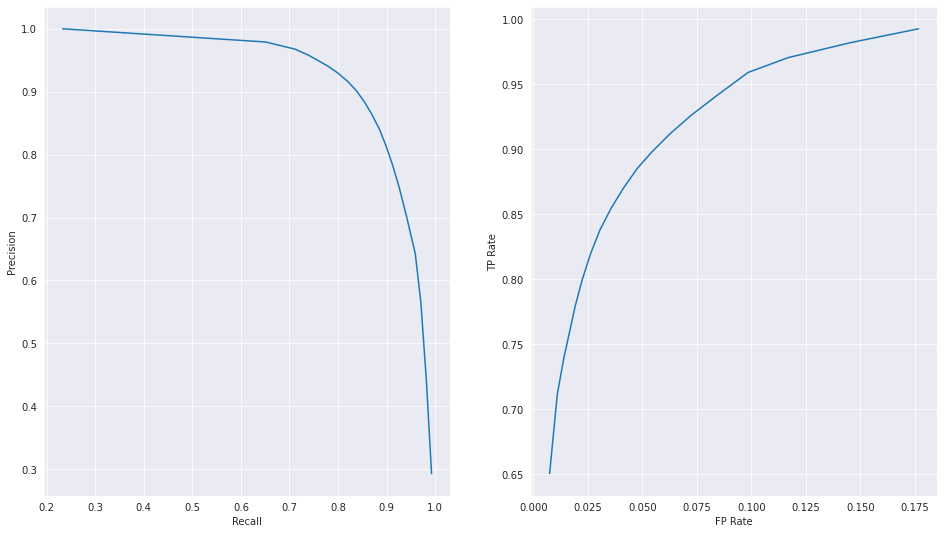

Per Class IOU {
    "cloud": 0.7696913148277739,
    "land": 0.9126062541022795,
    "water": 0.764717643577501
}


In [21]:
mets = metrics.compute_metrics(dl, inference_func2, opt2.num_class, label_names, thresholds_water=np.arange(0, 1, .05), plot=True)
metrics.plot_metrics(mets, label_names)